In [1]:
import pandas as pd
import numpy as np
import h2o
import lime
from lime import lime_tabular

from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.decomposition import PCA  # Principal component
from sklearn.linear_model import LinearRegression
from h2o.automl import H2OAutoML as ml
from h2o.estimators import H2OXGBoostEstimator

from functions.datacleaning import MoscowHousing as mh
from functions.clean import revert, write_predictions
from functions.distance import get_distance_coordinates, norm_features, PCA_plot

import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
XTrain = pd.read_csv("../prepared_data/train_prepared_category_3.csv")
XTest = pd.read_csv("../prepared_data/test_prepared_category_3.csv")

In [3]:
X_Train = XTrain.copy()
y_Train = XTrain["price"].copy()
y_Train = norm_features(y_Train)  # use z-scores to train
X_Test = XTest.copy()
drop_features = ["Unnamed: 0", 
                 "id", 
                 "street", 
                 "address"]
X_Train = X_Train.drop(drop_features, axis=1)
X_Train = X_Train.drop("price", axis=1)
X_Test = X_Test.drop(drop_features, axis=1)

In [4]:
X_Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23285 entries, 0 to 23284
Data columns (total 87 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   area_total             23285 non-null  float64
 1   area_kitchen           23285 non-null  float64
 2   area_living            23285 non-null  float64
 3   floor                  23285 non-null  float64
 4   rooms                  23285 non-null  float64
 5   ceiling                23285 non-null  float64
 6   building_id            23285 non-null  int64  
 7   latitude               23285 non-null  float64
 8   longitude              23285 non-null  float64
 9   district               23285 non-null  int64  
 10  constructed            22491 non-null  float64
 11  stories                23285 non-null  float64
 12  distance               23285 non-null  float64
 13  distance_metro         23285 non-null  float64
 14  seller_0.0             23285 non-null  int64  
 15  se

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_Train, y_Train, test_size=0.2, random_state=42)

In [6]:
modelCBR = CatBoostRegressor(
    n_estimators=1000,
    learning_rate=0.008,
    thread_count=-1,
    depth=7,
    silent=True,
    random_seed=42,
    bagging_temperature=0.2
#     od_type="Iter"
)

In [7]:
modelCBR.fit(X_train, y_train)

In [8]:
# Model prediction on split test set
cat_prediction = modelCBR.predict(X_test)

In [9]:
# Kaggle result running all data in category_3: 0.35557 (worse than first run)

cat_mse = round(mean_squared_error(cat_prediction, y_test), 5)
print('Test MSE:', cat_mse)

Test MSE: 0.20202


In [10]:
# Prediction on the actual test set
cat_prediction_REAL = modelCBR.predict(X_Test)

In [11]:
pred = pd.DataFrame(cat_prediction_REAL)

In [12]:
pred.head()

,0
0,-0.162352
1,-0.079324
2,-0.308742
3,-0.222903
4,-0.284702


In [13]:
# Kaggle score on this prediction in Step_3 is: 0.29393 (best single performance until now)
pred_R = revert(XTrain, pred)

In [14]:
pred_R.head()

,0
0,1.500931e+07
1,1.938025e+07
2,7.302800e+06
3,1.182166e+07
4,8.568355e+06


Text(0, 0.5, 'Ground Truth')

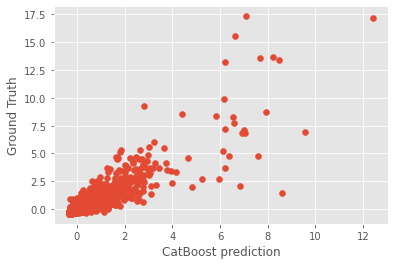

In [15]:
# Plot model performance (done on splitting test data)
plt.scatter(cat_prediction, y_test)
plt.xlabel('CatBoost prediction')
plt.ylabel('Ground Truth')

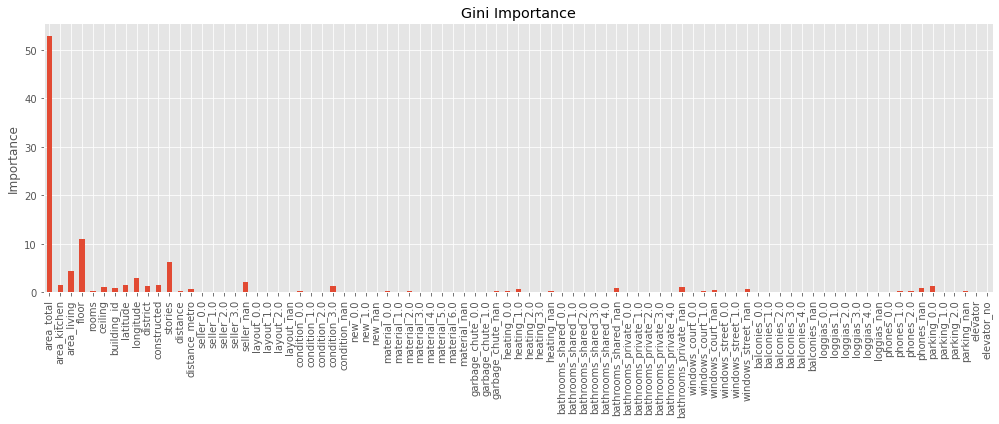

In [16]:
importances = modelCBR.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

In [17]:
write_predictions("cat_boost_category_3.csv", XTrain, XTest, cat_prediction_REAL)

In [18]:
result = pd.read_csv("cat_boost_category_3.csv")
result.head()

,id,price_prediction
0,23285,1.500931e+07
1,23286,1.938025e+07
2,23287,7.302800e+06
3,23288,1.182166e+07
4,23289,8.568355e+06


# SECOND RUN

# Removing values that did not give Gini importance

In [19]:
# CLEAN AND MAKE NEW BATCH
X_Train = XTrain.copy()
y_Train = XTrain["price"].copy()
y_Train = norm_features(y_Train)  # use z-scores to train
X_Test = XTest.copy()
drop_features = ["Unnamed: 0", 
                 "id", 
                 "street", 
                 "address"]
X_Train = X_Train.drop(drop_features, axis=1)
X_Train = X_Train.drop("price", axis=1)
X_Test = X_Test.drop(drop_features, axis=1)


X_train = X_Train.copy()
y_train = y_Train.copy()
X_test = X_Test.copy()

In [20]:
# Create new feature of parking
X_train["parking_yes"] = X_train.loc[:,["parking_1.0", 
                                     "parking_2.0"]
                                     ].apply(lambda x: x["parking_1.0"] +
                                             x["parking_2.0"] > 1, 
                                             axis=1)
X_test["parking_yes"] = X_test.loc[:,["parking_1.0", 
                                      "parking_2.0"]
                                   ].apply(lambda x: x["parking_1.0"] +
                                           x["parking_2.0"] > 1,
                                           axis=1)

X_train = X_train.astype({"parking_yes":np.int8})
X_test = X_test.astype({"parking_yes":np.int8})

# Removes are added in tested sequence!!!
drop_second = ["rooms", 
               "material_0.0", "material_1.0", "material_2.0", 
               "material_3.0", "material_4.0", "material_5.0",
               "material_6.0", "material_nan", 
               "balconies_0.0", "balconies_1.0", "balconies_2.0",
               "balconies_3.0", "balconies_4.0", "balconies_nan",
               "loggias_0.0", "loggias_1.0", "loggias_2.0",
               "loggias_3.0","loggias_4.0","loggias_nan",
               "parking_1.0", "parking_2.0",
               "new_0.0", "new_1.0", "new_nan",
               "garbage_chute_0.0", "garbage_chute_1.0", 
               "garbage_chute_nan",
               "elevator", "elevator_no"]

"""
Result mse getting worse when removed 
current best -----------> mse 0.19964 (kaggle: 0.35827) 
    --> best in first --> mse 0.29202 (kaggle: 0.29393)
Conclusion: even if the training model get better scores,
the kaggle get worse!!!

After adjusting area_kitchen to median in building:
mse -------> 0.19924 (only slightly better)

After adjusting area_living to median in building before district:
mse -------> 0.20061 (sligthly worse, but better that first)

Tried skipping:
"parking_nan", "parking_yes"
"layout_0.0", "layout_1.0", 
"layout_2.0", "layout_nan"

Results got worse (so included them again)

"""

X_train = X_train.drop(drop_second, axis=1)
X_test = X_test.drop(drop_second, axis=1)

In [21]:
#X_train.info()

In [22]:
X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [23]:
y_tr.head()

18332   -0.147333
18707   -0.356428
21356   -0.329046
19907   -0.200520
15697   -0.260687
Name: price, dtype: float64

In [24]:
y_te.head()

1603    -0.056990
22389   -0.296616
4143    -0.259406
19962    2.079368
7786     0.169893
Name: price, dtype: float64

In [25]:
modelCBR2 = CatBoostRegressor(n_estimators=1000,
                              learning_rate=0.008,
                              thread_count=-1,
                              depth=7,
                              silent=True,
                              random_seed=42,
                              bagging_temperature=0.2,
                              od_type="Iter")

In [26]:
modelCBR2.fit(X_tr, y_tr)

In [27]:
# Model prediction on split test set
cat_prediction2 = modelCBR2.predict(X_te)

In [28]:
# Kaggle result running all data in category_3: 0.35557 (worse than first cat boost run)
# Second kaggle: 0.35466 (with better adjusted area_kitchen, _living) --> only sligtly better

cat_mse2 = round(mean_squared_error(cat_prediction2, y_te), 5)
print('Test MSE:', cat_mse2)

Test MSE: 0.20061


In [29]:
# Prediction on the actual test set
cat_prediction_REAL2 = modelCBR2.predict(X_test)

Text(0, 0.5, 'Ground Truth')

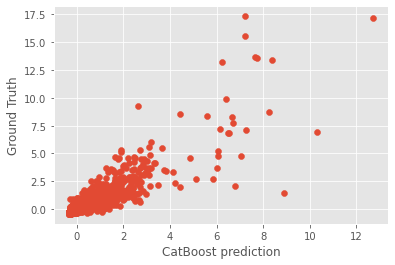

In [30]:
# Plot model performance (done on splitting test data)
plt.scatter(cat_prediction2, y_te)
plt.xlabel('CatBoost prediction')
plt.ylabel('Ground Truth')

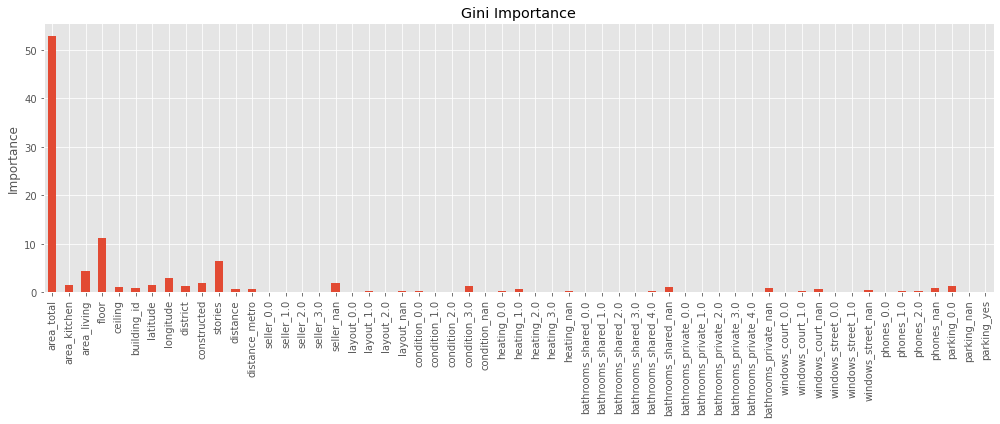

In [31]:
importances = modelCBR2.feature_importances_
forest_importances = pd.Series(importances, index=X_tr.columns)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

In [32]:
write_predictions("cat_boost_2_category_3.csv", XTrain, XTest, cat_prediction_REAL2)

In [33]:
result = pd.read_csv("cat_boost_2_category_3.csv")
result.head()

,id,price_prediction
0,23285,1.518861e+07
1,23286,1.942591e+07
2,23287,7.206888e+06
3,23288,1.116712e+07
4,23289,8.212827e+06


In [34]:
XTRAIN = X_train.copy()
y = y_train.copy()
XTEST = X_test.copy()

In [35]:
X_tr, X_te, y_tr, y_te = train_test_split(XTRAIN, y, test_size=0.2, random_state=42)

In [36]:
modelLGBM = lgb.LGBMRegressor(num_leaves=100,
                              max_depth=15, 
                              random_state=42,
                              metric='msle',
                              n_jobs=4, 
                              n_estimators=3000,
                              colsample_bytree=0.95,
                              subsample=0.9,
                              learning_rate=0.05)

In [37]:
modelLGBM.fit(XTRAIN, y)
lgbm_prediction = modelLGBM.predict(X_te)

In [38]:
# Kaggle score on this is: 0.39163
lgbm_mse = round(mean_squared_error(cat_prediction, y_te), 5)
print('Test MSE:', lgbm_mse)

Test MSE: 0.20202


Text(0, 0.5, 'Ground Truth')

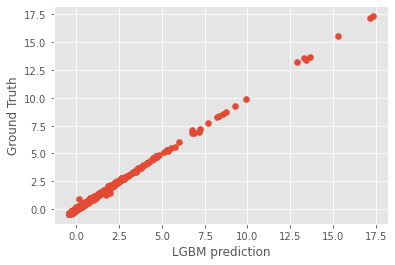

In [39]:
# Plot model performance (done on splitting test data)
plt.scatter(lgbm_prediction, y_te)
plt.xlabel('LGBM prediction')
plt.ylabel('Ground Truth')

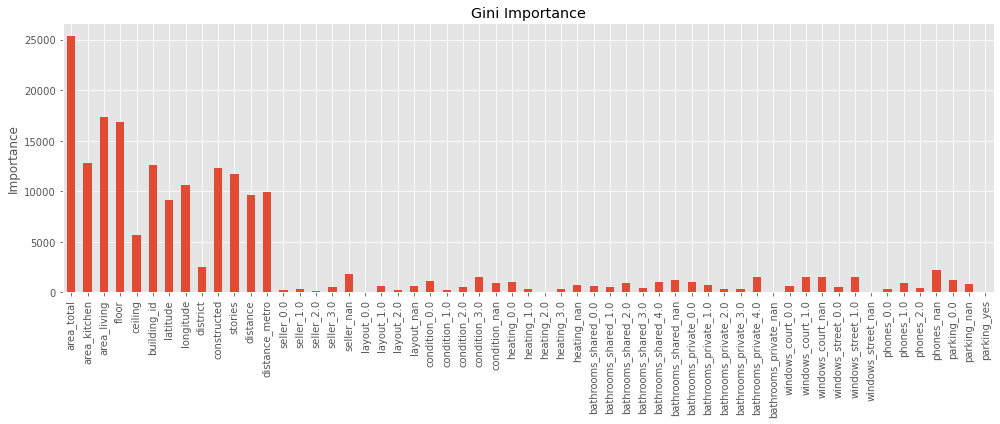

In [40]:
importances = modelLGBM.feature_importances_
forest_importances = pd.Series(importances, index=X_tr.columns)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

In [41]:
# Kaggle score: 0.39163 (worse than cat boost)

lgbm_prediction_final = modelLGBM.predict(XTEST)

In [42]:
write_predictions("lgbm_boost_category_3.csv", XTrain, XTest, lgbm_prediction_final)

In [43]:
result = pd.read_csv("lgbm_boost_category_3.csv")
result.head()

,id,price_prediction
0,23285,1.769937e+07
1,23286,1.607479e+07
2,23287,6.966781e+06
3,23288,7.970352e+06
4,23289,6.934222e+06
